# Simulacion de catálogos con errores astrométricos de Gaia

El objetivo de este tutorial es mostrar como pueden obtenerse simulaciones de la astrometria de Gaia. Este tipo de simulaciones permiten entender y analizar los efectos de los errores observacionales y la selección de la muestra en los parámetros de la población de base, evaluando así sesgos y efectos sistemáticos que se puedan estar introduciendo.

El punto de partida es la simulacion [GUMS](https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_simulation_tables/ssec_dm_gaia_universe_model.html) que se encuentra en la tabla _gaia_universe_model_ del archivo de Gaia. Esta simulación está basada en un [modelo de galaxia](https://ui.adsabs.harvard.edu/abs/2012A%26A...543A.100R/abstract) con el que se ha generado una "galaxia virtual", con objetos para los que disponemos de valores astrométricos libres de error (simulacion ideal).

A partir de esta simulación, en este tutorial aprenderemos a añadir a la astrometria "ideal" errores observacionales  similares a los de EDR3 usando el paquete _pygaia_; de esta forma generaremos observaciones de Gaia simuladas y con ellas podremos estudiar los efectos de los errores observacionales y de las selecciones realizadas en la muestra. Este procedimiento os permitirá generar simulaciones de Gaia basadas en vuestros propios modelos estelares.

El archivo de Gaia también proporciona una simulación completa del catálogo llamada [GOG](https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_simulation_tables/ssec_dm_gaia_universe_model.html) que se encuentra en la tabla _gaia_source_simulation_. Esta simulación está basada en GUMS, con todos los efectos observacionales añadidos, de manera que usando conjuntamente GUMS y GOG pueden también realizarse este tipo de estudios de forma más completa (ver por ejemplo el tutorial [Estimación de distancias a partir de las paralajes](./EstimacionDistancias/Tutorial-ED.ipynb)).

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pygaia.errors.astrometric import *

## Obtención de la simulación

Seleccionaremos una muestra a partir de GUMS recortando una sección del cielo:

    select U.ra, U.dec, U.barycentric_distance, U.pmra, U.pmdec, U.mag_g, U.mean_absolute_v
    from gaiaedr3.gaia_universe_model as U
    where U.ra>0 and U.ra<10 and U.dec>0.0 and U.dec<10 and U.mean_absolute_v>5 and U.mean_absolute_v<6  and U.mag_g<20

La muestra puede encontrarse en el fichero _GUMS.csv_ (11329 objetos). Nótese que este comando ADQL selecciona una muestra con:

* $0 < \alpha < 10$ y $0 < \delta < 10$ (selección de región del cielo)
* $G<20$ (corte en magnitud aparente)
* $5 < M_v < 6$ (corte en magnitud absoluta V para tener una selección más homogenea de estrellas en el diagrama HR)

In [2]:
data = pd.read_csv('GUMS.csv')

ra= data['ra'].values # en deg
dec= data['dec'].values # en deg
distance= data['barycentric_distance'].values # en pc
parallax= 1000./distance # in mas
pmra= data['pmra'].values # en mas/yr
pmdec= data['pmdec'].values # en mas/yr
mag_g= data['mag_g'].values # en mag

Generamos a continuación algunos histogramas para caracterizar la muestra seleccionada.

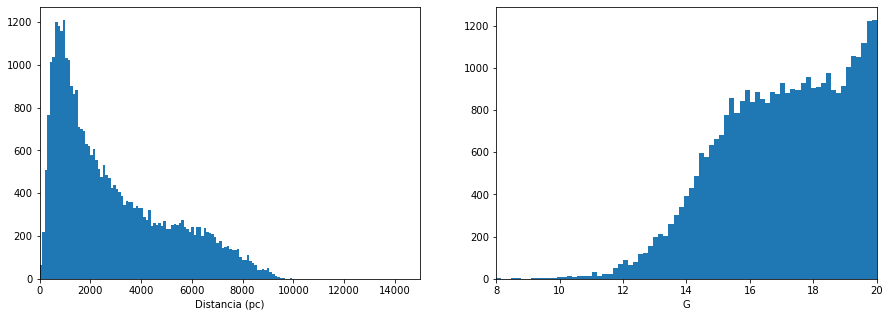

In [5]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(1,2,1)
plt.xlabel("Distancia (pc)")
plt.xlim(0,15000) # Limitamos el eje X para visualizar mejor la zona central
plt.hist(distance,100)

plt.subplot(1,2,2)
plt.xlabel("G")
plt.xlim(8,20) # Limitamos el eje X para visualizar mejor la zona central
plt.hist(mag_g,100)
plt.show()

## Añadimos los errores

Usamos las funciones de _pygaia.errors.astrometric_ para calcular los errores formales de la astrometria
$( \sigma_\alpha, \sigma_\delta, \sigma_\varpi, \sigma_{\mu_\alpha}, \sigma_{\mu_\delta} )$. A partir de ellos, asumiendo distribuciones de error gausianas, generamos errores individuales para cada valor.

In [7]:
# Calculamos los errores formales en función de la magnitud G
ra_error, dec_error = position_uncertainty(mag_g, release='dr3') # en muas
ra_error= ra_error/(3600*1000000) # en deg
dec_error= dec_error/(3600*1000000) # en deg

parallax_error = parallax_uncertainty(mag_g, release='dr3')/1000 # en mas
pmra_error, pmdec_error = proper_motion_uncertainty(mag_g, release='dr3') # en muas/yr
pmra_error= pmra_error/1000 # en mas/yr
pmdec_error= pmdec_error/1000 # en mas/yr


# Generamos valores observacionales individuales a partir de los valores simulados (sin error)
# asumiendo una distribución de error gausiana
ra_obs = np.random.normal(ra, ra_error)
ra_dec = np.random.normal(dec, dec_error)

parallax_obs= np.random.normal(parallax,parallax_error) # in mas

pmra_obs= np.random.normal(pmra,pmra_error) # in mas/yr
pmdec_obs= np.random.normal(pmdec,pmdec_error) # in mas/yr

Generamos histogramas de paralajes, real / observada para comparación. Nótese que han aparecido paralajes observadas negativas, mientras que las "reales" son siempre positivas como corresponde.

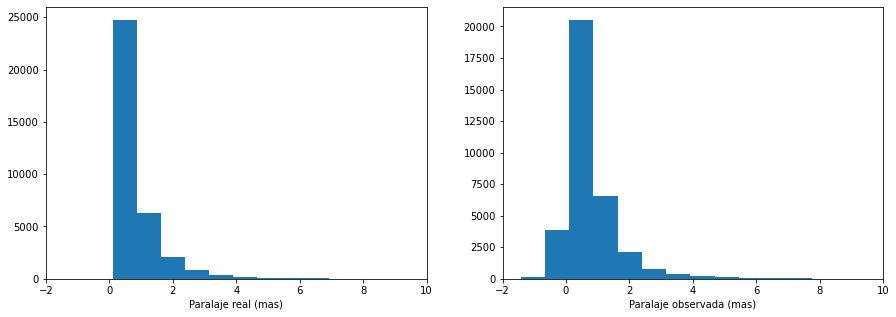

In [9]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplot(1,2,1)
plt.xlabel("Paralaje real (mas)")
plt.xlim(-2,10) # Limitamos el eje X para visualizar mejor la zona central
plt.hist(parallax,200)

plt.subplot(1,2,2)
plt.xlabel("Paralaje observada (mas)")
plt.xlim(-2,10) # Limitamos el eje X para visualizar mejor la zona central
plt.hist(parallax_obs,200)
plt.show()

## Ejercicio

A partir de la muestra anterior (o vuestra propia selección en el archivo), realizar los siguientes cortes:

* Eliminar las paralajes negativas
* Seleccionar solo las estrellas con paralajes de buena calidad: $\varpi/\sigma_\varpi > 5$
* Seleccionar solo las estrellas con paralajes de excelentes: $\varpi/\sigma_\varpi > 10$

Comprobar como estas selecciones afectan a la distribucion de distancias reales, a la distribución de magnitud G y a la distribución de movimientos propios.

## Lectura recomendada
    
[Inferring luminosity from a magnitude limited parallax survey](https://github.com/agabrown/astrometry-inference-tutorials/blob/master/luminosity-calibration/Luminosity_Inference_DistPrior.ipynb)    